경사하강법을 통해서 왜곡된 이미지를 
원래 이미지로 변환하는 예제

[준비]<br/>
1) 오염된 이미지=weird_function(정상이미지)<br/>
2) pickle로 오염된 이미지 -> broken_image_t.p 저장
[노이즈 이미지로 원본 이미지를 찾아가기]<br/>
3) broken_image_t.p를 읽어들임<br/>
4) randn으로 noise 이미지를 만듬<br/>
5) new 오염 이미지 = weird_function(noise 이미지)<br/>
4) loss = new오염이미지-오염이미지<br/>
5) noise이미지가 loss미치는 영향(기울기)을 구한다<br/>
6) new오염이미지-오염이미지가 0에 가까워지도록
  학습<br/>
7) noise이미지는 원본오염이미지가 weird_function을 거치기전과 유사하게 변화<br/>
8) loss가 아주 적게 나오는 것을 확인했으면
  noise이미지를 출력한다<br/>


<ol>
  <li>A는 레전드 배우, B는 아마추어</li>
  <li>A 마음(정상이미지) -> 뇌(weird_function) -> A 연기(broken_image)</li>
  <li>B 마음(모른다) -> 뇌(werid_function)
  -> B 연기(hyporthesis)
  <li> B연기과 A연기의 차이</li>
  <li>A연기과 유사해지도록 노력</li>
  <li>몇번째에 유사해질지는 모른다.
  그냥 반복한다</li>
  <li>언젠가는 연기가 거의 동일해진다</li>
  <li>B는 자신의 마음을 보고, A는 저런 마음이었겠구나. 아하!</li>
  <li>메소드 연기</li>
</ol>

In [46]:
import torch
import pickle
import matplotlib.pyplot as plot

In [47]:
# Colab에서 우리 계정 구글드라이브 마운트(연결)
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


torch.Size([10000])
1


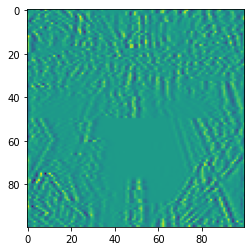

In [48]:
# 이미지를 pickle로 파일에 저장해놓은 것을 
# 읽어들인다
# 10000개의 1차원 tensor이므로
# 화면에 출력하기 위해 view(100, 100)로 2차원 (100, 100) 으로 변환후 출력

# 기이한 이미지 = weird_function(정상 이미지)
# 기이한 이미지를 파일(broken_image_t.p)로 저장
image_path = '/content/drive/MyDrive/Colab Notebooks/broken_image_t.p'
broken_image = torch.FloatTensor(pickle.load(open(image_path, 'rb'), encoding='latin1'))
print(broken_image.size())
print(broken_image.ndimension())
plot.imshow(broken_image.view(100, 100))

In [49]:
# x에 들어온 값을 기이하게 변환하는 함수(해석할 필요 없음)
def weird_function(x, n_iter=5):
  h = x
  filt = torch.tensor([-1./3, 1./3, -1./3])
  for i in range(n_iter):
    zero_tensor = torch.tensor([1.0 * 0])
    h_l = torch.cat((zero_tensor, h[:-1]), 0)
    h_r = torch.cat((h[1:], zero_tensor), 0)
    h = filt[0] * h + filt[2] * h_l + filt[1] * h_r
    if i%2 == 0:
      h = torch.cat((h[h.shape[0]//2:], h[:h.shape[0]//2]), 0)
  return h

In [50]:
# 2개 입력 텐서의 차이를 반환하는 함수(얼마냐 다르냐)
def distance_loss(hypothesis, broken_image):
  return torch.dist(hypothesis, broken_image)

torch.Size([10000])
1


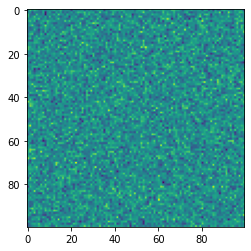

In [51]:
# 정규분표 난수를 이용해 float타입 10000개를 가지는 tensor를 생성해라
random_tensor = torch.randn(10000, dtype=torch.float)
print(random_tensor.size())
print(random_tensor.ndimension())
plot.imshow(random_tensor.view(100, 100))

# 경사하강법
# ; weight가 error에 미치는 영향(기울기)을 구해서
#   조금씩(lr) 기울기의 반대방향으로 이동해서 error를 줄여나가는 것
# 기존 기울기 - 학습률*기울기 값
lr = 0.8

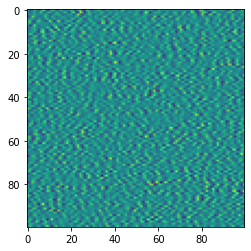

In [52]:
hypothesis = weird_function(random_tensor)
plot.imshow(hypothesis.view(100, 100).data)

In [53]:
for i in range(0, 20000):
  # random_tensor가 연쇄함수를 통해서
  # 최종요소에 미치는 기울기를 구하고 싶다
  # loss = z(y(x))
  random_tensor.requires_grad_(True)             # x = torch.tensor(3.5)
  hypothesis = weird_function(random_tensor)     # y = x**2 
  loss = distance_loss(hypothesis, broken_image) # z = y**3 + y**2 + 10
  loss.backward()   # random_tensor가 loss에 미치는 영향(기울기)를 구한다
  with torch.no_grad():  # torch에서 제공하는 경사하강법을 안쓰겠다.
    # 직접 우리가 경사하강법을 진행한다
    # 도출 이미지 = noise 이미지 - 학습률 * noise 이미지의 기울기
    # loss가 줄어드는 방향으로 random_tensor의 값이 변화한다
    # hypothesis가 broken_image를 점점 닮아간다.
    random_tensor = random_tensor - lr*random_tensor.grad
  if i%1000==0:
    print('Loss at {} = {}'.format(i, loss.item()))

Loss at 0 = 12.151517868041992
Loss at 1000 = 1.1389459371566772
Loss at 2000 = 0.5490201711654663
Loss at 3000 = 0.3786240518093109
Loss at 4000 = 0.29816219210624695
Loss at 5000 = 0.249113529920578
Loss at 6000 = 0.214244082570076
Loss at 7000 = 0.18682706356048584
Loss at 8000 = 0.16370977461338043
Loss at 9000 = 0.14325711131095886
Loss at 10000 = 0.12456341087818146
Loss at 11000 = 0.10709685832262039
Loss at 12000 = 0.09052383899688721
Loss at 13000 = 0.07462359964847565
Loss at 14000 = 0.05924481526017189
Loss at 15000 = 0.044281620532274246
Loss at 16000 = 0.029661323875188828
Loss at 17000 = 0.02115197479724884
Loss at 18000 = 0.021165983751416206
Loss at 19000 = 0.021167617291212082


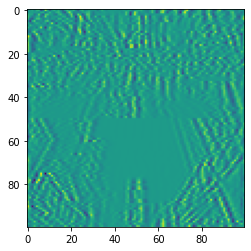

In [54]:
plot.imshow(hypothesis.view(100, 100).data)

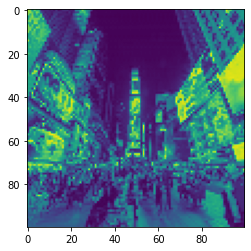

In [55]:
plot.imshow(random_tensor.view(100, 100).data)